# Error Forecasting for Ukraine
In this notebook the method is described with which the error forecasting is done.

## Imports
First we need to import all important libraries and specify which GPU (if available) is used.

In [2]:
import gc
import os
import time
# I need to set a specific GPU to use. Set to -1 if no GPU is present
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import data as data_tensor
import tensorflow_probability as tfp
from statsmodels.tsa.seasonal import seasonal_decompose


## Load Data
First of all we have to load in all data given from the deterministic model. I needed both datasets because the all predictors dataframe did not have the day of month. I had to correct it in one of the two datasets already so I left the fix in, in order to not care about that anymore ;-)

In [3]:
from pathlib import Path

data_folder = Path('C:/path/to/files')

file_to_open = data_folder / "basic_structure_df.csv"
file_to_open2 = data_folder / "all_predictors_df2.csv"


data = pd.read_csv(file_to_open)
data_2=pd.read_csv(file_to_open2)

### Read in Data

In [4]:
data_2


,year,month,day,hour,temp,HD,CD,HD_2,CD_2,HD_3,...,mon,tue,wed,thu,fri,sat,sun,mid_load,index,value
0,2013,1,HD,0,-4.097832,22.397832,0.0,501.662880,0.0,11236.160937,...,0,1,0,0,0,0,0,77.253881,1,-157.162194
1,2013,1,WD,0,-3.919938,22.219938,0.0,493.725635,0.0,10970.552890,...,0,0,1,0,0,0,0,1593.337215,2,157.162194
2,2013,1,WD,0,-1.456409,19.756409,0.0,390.315703,0.0,7711.236732,...,0,0,0,1,0,0,0,2274.087215,3,-679.388545
3,2013,1,WD,0,-0.694651,18.994651,0.0,360.796777,0.0,6853.208966,...,0,0,0,0,1,0,0,2413.670548,4,-356.130926
4,2013,1,WE,0,-1.376359,19.676359,0.0,387.159097,0.0,7617.881321,...,0,0,0,0,0,1,0,1948.878881,5,-12.642208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2020,12,WE,0,-4.305597,22.605597,0.0,511.013036,0.0,11551.754982,...,0,0,0,0,0,0,1,2229.190868,2916,452.979150
2916,2020,12,WD,0,-2.418863,20.718863,0.0,429.271264,0.0,8894.012316,...,1,0,0,0,0,0,0,3881.857534,2917,1136.773285
2917,2020,12,WD,0,0.772182,17.527818,0.0,307.224421,0.0,5384.973875,...,0,1,0,0,0,0,0,3417.482534,2918,637.908152
2918,2020,12,WD,0,1.728469,16.571531,0.0,274.615625,0.0,4550.801210,...,0,0,1,0,0,0,0,2957.440868,2919,443.503123


### Add missing column

In [5]:
data_2 ['day_of_month'] = data['day_of_month']
data = data_2.drop(columns=['index','day', 'hour', 'WD', 'wday', 'mid_load'])
data = data.drop(columns=['HD','CD', 'HD_2', 'CD_2', 'HD_3', 'CD_3','HD_m1','HD_m2','CD_m1','CD_m2'])
data

,year,month,temp,temp_m1,temp_m2,summer,winter,jan,feb,mar,...,ToD,mon,tue,wed,thu,fri,sat,sun,value,day_of_month
0,2013,1,-4.097832,-4.097000,-4.097000,0,1,1,0,0,...,1,0,1,0,0,0,0,0,-157.162194,1
1,2013,1,-3.919938,-4.097832,-4.097000,0,1,1,0,0,...,0,0,0,1,0,0,0,0,157.162194,2
2,2013,1,-1.456409,-3.919938,-4.097832,0,1,1,0,0,...,0,0,0,0,1,0,0,0,-679.388545,3
3,2013,1,-0.694651,-1.456409,-3.919938,0,1,1,0,0,...,0,0,0,0,0,1,0,0,-356.130926,4
4,2013,1,-1.376359,-0.694651,-1.456409,0,1,1,0,0,...,0,0,0,0,0,0,1,0,-12.642208,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2020,12,-4.305597,-1.785778,-0.803576,0,1,0,0,0,...,0,0,0,0,0,0,0,1,452.979150,27
2916,2020,12,-2.418863,-4.305597,-1.785778,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1136.773285,28
2917,2020,12,0.772182,-2.418863,-4.305597,0,1,0,0,0,...,0,0,1,0,0,0,0,0,637.908152,29
2918,2020,12,1.728469,0.772182,-2.418863,0,1,0,0,0,...,0,0,0,1,0,0,0,0,443.503123,30


Add elections in 2014 and 2019

In [5]:
data['elections']= 0
data['elections'][data['year']==2019]=1
data['elections'][data['year']==2014]=1
data['elections'][data['month']>5]=0
data[data['year']==2019]

C:\Users\s0536\Downloads\WPy-3710\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\s0536\Downloads\WPy-3710\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\s0536\Downloads\WPy-3710\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,year,month,temp,temp_m1,temp_m2,summer,winter,jan,feb,mar,...,mon,tue,wed,thu,fri,sat,sun,value,day_of_month,elections
2190,2019,1,-5.385798,-4.097000,-4.097000,0,1,1,0,0,...,0,1,0,0,0,0,0,-1630.171371,0,1
2191,2019,1,-2.278521,-5.385798,-4.097000,0,1,1,0,0,...,0,0,1,0,0,0,0,-1041.882954,0,1
2192,2019,1,-4.099056,-2.278521,-5.385798,0,1,1,0,0,...,0,0,0,1,0,0,0,-692.439419,0,1
2193,2019,1,-6.244454,-4.099056,-2.278521,0,1,1,0,0,...,0,0,0,0,1,0,0,-71.930059,0,1
2194,2019,1,-7.316396,-6.244454,-4.099056,0,1,1,0,0,...,0,0,0,0,0,1,0,-49.272939,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,2019,12,1.240626,2.371258,2.290928,0,1,0,0,0,...,0,0,0,0,1,0,0,-578.798690,0,0
2551,2019,12,0.186297,1.240626,2.371258,0,1,0,0,0,...,0,0,0,0,0,1,0,-114.236316,0,0
2552,2019,12,-1.906868,0.186297,1.240626,0,1,0,0,0,...,0,0,0,0,0,0,1,-605.053519,0,0
2553,2019,12,-3.346923,-1.906868,0.186297,0,1,0,0,0,...,1,0,0,0,0,0,0,-1258.229678,0,0


### Fix wrong values

In [12]:
data_with_wrong_reports = data[data['day_of_month']==0]
for year in data['year'].unique():
    year_data = data_with_wrong_reports[data_with_wrong_reports['year']==year]
    for month in year_data['month'].unique():
        month_data = year_data[year_data['month']==month]
        increasing_number = pd.Series(range(1, len(month_data)+1), index=month_data.index)
        data.loc[month_data.index, 'day_of_month'] = increasing_number 

### which features are available?
I just took a look at what features are available in the dataset.

In [13]:
data.columns

Index(['year', 'month', 'temp', 'temp_m1', 'temp_m2', 'summer', 'winter',
       'jan', 'feb', 'mar', 'apr', 'mai', 'jun', 'jul', 'aug', 'sep', 'okt',
       'nov', 'dec', 'numday', 'we', 'ToD', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'value', 'day_of_month', 'Year sin', 'Year cos'],
      dtype='object')

## First Visualization

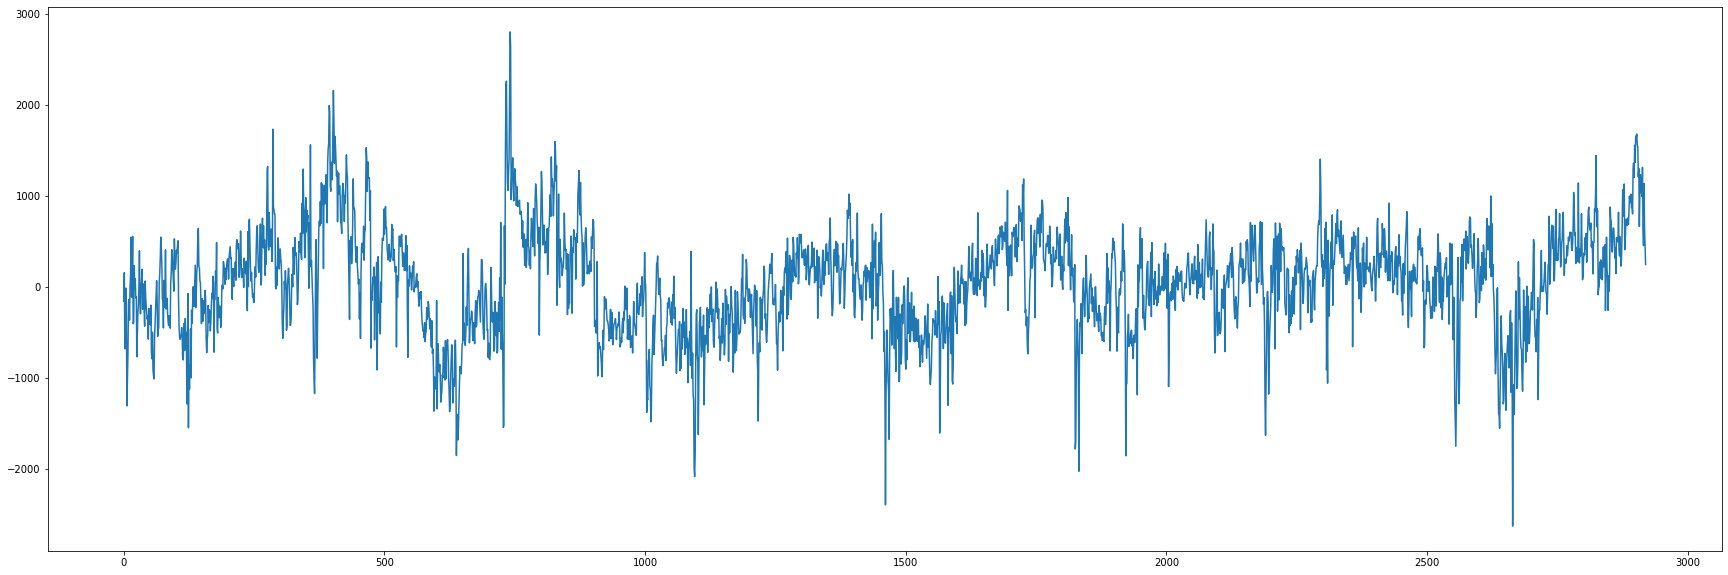

In [27]:
fig, (ax1) = plt.subplots(1,1, figsize=(30,10))
plt.plot(data['value'])

# Fast-Forwarding to Neural Network


## Preliminary Things
- Set the datetime as index
- Initialize the scaler 
- add Sin and Cosine representation of the year

In [16]:
data.index = pd.to_datetime(data['month'].astype(str) + '-' + data['day_of_month'].astype(str)+ '-'+ data['year'].astype(str))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [17]:
def sine_cosine_year(data):
    day = 24 * 60 * 60
    year = (365.2425) * day
    timestamp_s = data.index.map(pd.Timestamp.timestamp)
    data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    return data
data = sine_cosine_year(data)

## Define the Model
We use an Encoder-Decoder Model with Attention (Luong) and LSTM. 

An Encoder-Decoder is a Model which build up on two parts: the encoder and the decoder. Both are not connected directly because the input into the encoder is somehow not shown to the decoder besides a representation. 

### Encoder
The Encoder takes up what we give him as input. In this case all historical data, with its respective features. With these data it tries to get an idea and extract information. This part is unsupervised as we do not know what exactly it does.

### Decoder
The decoder is doing the forecasting. It is build the same as the encoder (which is mandatory) because we have to transfer the information between them. The decoder takes in future features and tries to estimates based on the knowledge extracted by the encoder. 

### Attention
A problem which might arise is, that when we have really long sequences, it might be that an encoder-decoder modell gets somehow lost, because it is using it's own predictions at some point. With attention we can tell which parts in the future data is important to get the right solution. 

### LSTM
Long Short-Term Memory is just a more sophisticated RNN. These type of networks need a 3D-input which is organized in: (sample, timestep, features)


### Lets Define it!

In [23]:

class cnn_model:
    def __init__(self, input_length, output_length):
        self.model = None
        self.input_length = input_length
        self.output_length = output_length
        self.data = None
        
    def load_model(self,features_cnn, features_decoder):
        n_units_1 = 64
        n_units_2 = 32
        
        # define training encoder
        input_shape = (self.input_length, features_cnn)
        encoder_inputs = tf.keras.layers.Input(shape=input_shape, name='Encoder Input')
        # first encoder layer
        lstm_enc = tf.keras.layers.LSTM(n_units_1, activation='tanh', return_state=True,return_sequences=True, dropout=0.1, name = 'LSTM_encoder_1')
        encoder_outputs_1, state_h_1, state_c_1 = lstm_enc(encoder_inputs)
        encoder_states_1 = [state_h_1, state_c_1]
        # second encoder layer
        lstm_enc_2 = tf.keras.layers.LSTM(n_units_2, activation='tanh', return_state=True, dropout=0.1, name = 'LSTM_encoder_2')
        encoder_outputs_2, state_h_2, state_c_2 = lstm_enc_2(encoder_outputs_1)
        encoder_states_2 = [state_h_2, state_c_2]
        encoder_states_1  = [state_h_1, state_c_1]
        
        # define training decoder
        input_decoder = tf.keras.layers.Input(shape=(self.output_length, features_decoder), name = 'Decoder Input')
        decoder_lstm_1 = tf.keras.layers.LSTM(n_units_1, activation='tanh', return_sequences=True, return_state=True, dropout=0.1, name = 'LSTM_decoder_1')
        decoder_outputs_1, _, _ = decoder_lstm_1(input_decoder, initial_state=encoder_states_1)
        attention = tf.keras.layers.Attention(causal = True)([decoder_outputs_1, encoder_outputs_1])
        concat_out = tf.keras.layers.Concatenate()([decoder_outputs_1, attention])
        decoder_lstm_2 = tf.keras.layers.LSTM(n_units_2, activation='tanh', return_sequences=True, return_state=True, dropout=0.1, name = 'LSTM_decoder_2')
        decoder_outputs_2, _, _ = decoder_lstm_2(concat_out, initial_state=encoder_states_2)
        attention = tf.keras.layers.Attention(causal = True)([decoder_outputs_2, encoder_outputs_2])
        concat_out = tf.keras.layers.Concatenate()([decoder_outputs_2, attention])
        dense_output = tf.keras.layers.Dense(1, activation='relu')
        dense_output_output = dense_output(concat_out)
        # define training encoder-decoder
        model = tf.keras.Model([encoder_inputs, input_decoder], [dense_output_output])       
        # return all models
        return model
    
    def supervised_data(self, data, train_test_split, scaler_x, scaler_y):
        # we need three containers storing: encoder data, decoder data and target data
        encoder_in_train = []
        decoder_in_train = []
        target_train = []
        # here i split the defined input length and output length from the data which is then the data which is needed to do the forecast on 2019 and 2020
        data_for_validation = data.iloc[-self.input_length - self.output_length:, :]
        # this data is used to calculate the train dataset. it is important to note that I split the forecasting horizon from the dataset. This ensures that we do not have future information in dataset
        data_for_train = data.iloc[:-self.output_length, :]
        # get all column names to split the features from the target values
        train_columns= data_for_train.drop(columns=['value']).columns
        # now we have to fit the scaler and transform the data in a range of 0 to 1
        # it is important that we split the data before because otherwise we would make new information about min and maximum values available for the network!
        # I always use two scalers for that one for features and one for target values
        data_for_train[train_columns] = scaler_x.fit_transform(data_for_train[train_columns])
        data_for_train['value'] = scaler_y.fit_transform(data_for_train['value'].values.reshape(-1,1))
        # with the fitted scaler we now transform the features of the future data. 
        data_for_validation[train_columns] = scaler_x.transform(data_for_validation[train_columns])
        data_for_validation['value'] = scaler_y.transform(data_for_validation['value'].values.reshape(-1,1))
        # lets get our training dataset prepared
        # we iterate over all data in the dataset and we use i as the first datapoint from which our dataset starts
        # i + input_lenghth -> data for encoder
        # i + input_length until i + input_length + output_length -> data for decoder
        for i in range(0, len(data_for_train) - self.output_length - self.input_length):
            encoder_index = i + self.input_length
            decoder_index = i + self.input_length + self.output_length
            encoder_in_train.append(
                data_for_train.iloc[i:encoder_index, :].values.reshape(self.input_length, data_for_train.shape[1]))
            # as discussed I drop here future temperature values
            decoder_in_train.append(data_for_train.iloc[encoder_index:decoder_index, :].drop(
                columns=['temp', 'temp_m1', 'temp_m2', 'value']).values.reshape(self.output_length,
                                                                                data_for_train.shape[1] - 4))
            target_train.append(
                data_for_train.iloc[encoder_index:decoder_index, :]['value'].values.reshape(self.output_length, 1))
        # for simplicity we use tensorflow dataset because we can then do a train/test split and batching easily but first we have to glue our data  together as needed
        # therefor we combine our input data into one tensorflow dataset
        input_tensors_train = data_tensor.Dataset.from_tensor_slices((encoder_in_train, decoder_in_train))
        # we put our output data into another dataset
        output_tensor_train = data_tensor.Dataset.from_tensor_slices(np.array(target_train))
        # now we can zip them together and have a full encoder_in, decoder_in, target dataset. Shuffling should ensure that we do not have just e.g. the first three years for training, than the following 2 in test
        # it is important that we get latest changes into it aswell. Thats why I like shuffling
        total_train_data = data_tensor.Dataset.zip((input_tensors_train, output_tensor_train)).shuffle(192)
        # now we do the train/test split with the shuffled data
        train_data = total_train_data.take(int(len(decoder_in_train) * train_test_split))
        test_data = total_train_data.skip(int(len(decoder_in_train) * train_test_split))
        # lastly we have to define the encoder-in, decoder_in and output for 2019 and 2020
        encoder_in_val = np.array(data_for_validation.iloc[0:self.input_length, :].values).reshape(1, self.input_length,data_for_train.shape[1] )
        decoder_in_val = np.array(data_for_validation.iloc[self.input_length:, :].drop(
            columns=['temp', 'temp_m1', 'temp_m2', 'value']).values).reshape(1, self.output_length,
                                                                                data_for_train.shape[1] - 4)
        target_val = np.array(data_for_validation.iloc[self.input_length:, :]['value'].values)
        self.data = {'train': train_data, 'test': test_data, 'val': [encoder_in_val, decoder_in_val, target_val]}
        return self.data
    
    
cnn = cnn_model(365, 365*2)
#model = cnn.load_model(43, 39)
model = cnn.load_model(33, 29)
train_dataset = cnn.supervised_data(data, 0.75, scaler_x, scaler_y)

C:\Users\s0536\Downloads\WPy-3710\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\s0536\Downloads\WPy-3710\python-3.7.1.amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\s0536\Downloads\WPy-3710\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

NameError: name 'data_for_train' is not defined

The following command shows how our model looks like:
We can also see how we transfer information from the encoder to the decoder here. Take a look at the "Connected to" column. We see that LSTM_decoder_1 is somehow connected to LSTM_encoder_1 (respectively the same for 2). We transfer infromation gained by the encoder to the decoder by the internal states. For layer 1 as an example the attention mechanism works as follows:

Attention for the first layer needs output of LSTM_encoder_1 and LSTM_decoder_1. The generated information has then to be concatenated to the output of LSTM_decoder_1 in order to do the highlighting. This can then be fed to the next layer.

In [20]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder Input (InputLayer)     [(None, 365, 34)]    0           []                               
                                                                                                  
 Decoder Input (InputLayer)     [(None, 730, 30)]    0           []                               
                                                                                                  
 LSTM_encoder_1 (LSTM)          [(None, 365, 64),    25344       ['Encoder Input[0][0]']          
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

### Custom Training
This is a custom training loop. If you want to do training more then once, then you have to also rerun this cell!

In [24]:
@tf.function
def train_step(model, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric):
    """
    Function

        Training on one batch

    Parameter

        model : keras.model
            ai model for forecasting

        x_batch_train : tensor.batch
            batched tensor containing training feature data

        y_batch_train : tensor.batch
            batched tensor containing training measurement data

        optimizer : keras.optimizer
            Optimizer used for training

        loss_fn : keras.loss_function
            loss function to calculate accuracy
        train_acc_metric : keras.loss_function

            accuracy metric

    Return

        loss_value : keras.loss
            loss value
    """
    with tf.GradientTape() as tape:
        logits = model(x_batch_train, training=True)  # Logits for this minibatch
        loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y_batch_train, logits)
    _ = gc.collect()
    return loss_value


@tf.function
def test_step(model, x_batch_val, y_batch_val, val_acc_metric):
    """
    Function

        Testing on one batch


    Parameter

        model : keras.model
            ai model for forecasting

        x_batch_val : tensor.batch
            batched tensor containing training feature data

        y_batch_val : tensor.batch
            batched tensor containing training measurement data

        val_acc_metric : keras.loss_function
            accuracy metric

    Return

        None
    """
    val_logits = model((x_batch_val), training=False)
    val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    _ = gc.collect()


def train_test_loss_graph(train_loss, test_loss, path_pre, part, time_now):
    """

    Function

        draws train test loss picture

    Parameter

        train_loss : list
            list of train_losses

        test_loss
            list of test_losses

        path_pre : str
            path to folder to save to

        part : str
            which algorithm is trained (e.g. PV-Long)

        time_now : pd.datetime
            current time

    Return

        None / Written to file

    """
    path_folder = f'{path_pre}/resources/02_models/{part}/training_results/'
    os.makedirs(path_folder, exist_ok=True)
    full_path = f'{path_pre}/resources/02_models/{part}/training_results/{str(time_now).replace(":", "_")}.png'
    train_loss = np.array(train_loss)
    test_loss = np.array(test_loss)
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.savefig(full_path)


def train_multi_input(model, train_dataset, val_dataset, train_acc_metric, optimizer, loss_fn, val_acc_metric, patience,
                      epochs=1):
    """
    Function

        Training routine for AI models

    Parameter

        model : keras.model
            AI - Model to train

        train_dataset : dict
            Data to train Algorithm with

        val_dataset : dict
            Data to evaluate Algorithm with

        train_acc_metric : tf.keras.Metric
            Metric applied to quantify training

        val_acc_metric : tf.keras.Metric
            Metric applied to quantify validation

        optimizer : tf.keras.Optimizer
            Optimizer used to train algorithm

        loss_fn : tf.keras.Loss
            loss function used by optimizer for training

        patience : int
            Epochs to wait before stopping training

        epochs : int
            Epochs to train Network at maximum


    Return

        trained model

    """
    best_loss = None
    wait = 0
    best_val_acc = None
    # for cb in callback:
    #    cb.on_train_begin()
    l = 0
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        start_time = time.time()
        # Iterate over the batches of the dataset.
        for train_data in enumerate(train_dataset):
            step = train_data[0]
            y_batch_train = train_data[1][-1]
            encoder_in = train_data[1][0][0]
            decoder_in = train_data[1][0][1]
            x_batch_train = [encoder_in, decoder_in]
            loss_value = train_step(model, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric)
            loss_value = train_step(model, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric)

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for val_data in enumerate(val_dataset):
            step = val_data[0]
            y_batch_val = val_data[1][-1]
            decoder_in = val_data[1][0][1]
            encoder_in = val_data[1][0][0]
            test_step(model, [encoder_in, decoder_in], y_batch_val, val_acc_metric)

        val_acc = val_acc_metric.result()
        train_loss.append(float(train_acc))
        test_loss.append(float(val_acc))

        val_acc_metric.reset_states()
        if best_loss is None:
            best_loss = val_acc
            best_weights = model.get_weights()
            wait = 0
            best_val_acc = [0, val_acc]
        elif best_loss > val_acc:
            best_weights = model.get_weights()
            #if val_acc >= best_loss - 0.00005:
            #    wait += 1
            #else:
            wait = 0
            best_val_acc = [epoch, val_acc]
            best_loss = val_acc
        else:
            wait += 1
            # print(wait)
            if wait == 30 or wait == 40 or wait == 45:
                print('New LR: ', K.eval(optimizer.lr) * 0.2)
                # print(wait)
                K.set_value(optimizer.learning_rate, K.eval(optimizer.lr) * 0.2)
            if wait >= patience:
                model.set_weights(best_weights)
                break
        print(
            f"Epoch {epoch}: training loss: {float(train_acc)}, validation loss: {float(val_acc)}, time elapsed: {time.time() - start_time}, wait: {wait}")
    model.set_weights(best_weights)
    tf.keras.backend.clear_session()
    _ = gc.collect()
    return model, train_loss, test_loss

### Training

Finally the training part. A loss function (MSE) and an optimizer (Adam) are specified

In [25]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
train_acc_metric = tf.keras.metrics.MeanSquaredError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

model, train_loss, test_loss = train_multi_input(model, train_dataset.get('train').batch(128), train_dataset.get('test').batch(48),
                                                                     train_acc_metric=train_acc_metric,
                                                                     optimizer=optimizer, loss_fn=loss_fn,
                                                                     val_acc_metric=val_acc_metric, patience=50, epochs=400)

Epoch 0: training loss: 0.04562492296099663, validation loss: 0.013708890415728092, time elapsed: 82.50001883506775, wait: 0
Epoch 1: training loss: 0.019405614584684372, validation loss: 0.008616435341536999, time elapsed: 69.27300119400024, wait: 0
Epoch 2: training loss: 0.013278722763061523, validation loss: 0.00888636615127325, time elapsed: 89.41630148887634, wait: 1
Epoch 3: training loss: 0.012154548428952694, validation loss: 0.00865271408110857, time elapsed: 75.3456974029541, wait: 2
Epoch 4: training loss: 0.01164019014686346, validation loss: 0.008132879622280598, time elapsed: 94.8846218585968, wait: 0
Epoch 5: training loss: 0.011066507548093796, validation loss: 0.007499904837459326, time elapsed: 88.52486395835876, wait: 0
Epoch 6: training loss: 0.01075037196278572, validation loss: 0.007041274104267359, time elapsed: 97.9822986125946, wait: 0
Epoch 7: training loss: 0.010293119587004185, validation loss: 0.006473314482718706, time elapsed: 89.73802638053894, wait: 0


Epoch 65: training loss: 0.003199508413672447, validation loss: 0.002341327490285039, time elapsed: 108.18346881866455, wait: 2
Epoch 66: training loss: 0.0029998011887073517, validation loss: 0.0024421296548098326, time elapsed: 108.11314582824707, wait: 3
Epoch 67: training loss: 0.0033568916842341423, validation loss: 0.004074759315699339, time elapsed: 4517.052645206451, wait: 4
Epoch 68: training loss: 0.003521993523463607, validation loss: 0.0025741690769791603, time elapsed: 105.55689072608948, wait: 5
Epoch 69: training loss: 0.0029429926071316004, validation loss: 0.0022908891551196575, time elapsed: 105.08458828926086, wait: 6
Epoch 70: training loss: 0.0028336485847830772, validation loss: 0.0025584513787180185, time elapsed: 107.03223180770874, wait: 7
Epoch 71: training loss: 0.002579041523858905, validation loss: 0.002172378823161125, time elapsed: 108.28594422340393, wait: 0
Epoch 72: training loss: 0.0025438738521188498, validation loss: 0.002159000374376774, time elaps

Epoch 129: training loss: 0.0020737594459205866, validation loss: 0.0016794143011793494, time elapsed: 117.06313180923462, wait: 5
Epoch 130: training loss: 0.0021875042002648115, validation loss: 0.0017167337937280536, time elapsed: 116.51617860794067, wait: 6
Epoch 131: training loss: 0.0022939788177609444, validation loss: 0.0017417185008525848, time elapsed: 116.19938254356384, wait: 7
Epoch 132: training loss: 0.0019583189859986305, validation loss: 0.001965703908354044, time elapsed: 116.19007563591003, wait: 8
Epoch 133: training loss: 0.0018424942390993237, validation loss: 0.0016584075056016445, time elapsed: 116.98360300064087, wait: 9
Epoch 134: training loss: 0.0019487451063469052, validation loss: 0.0015837616520002484, time elapsed: 117.02315998077393, wait: 0
Epoch 135: training loss: 0.0023579495027661324, validation loss: 0.00247776135802269, time elapsed: 117.16506242752075, wait: 1
Epoch 136: training loss: 0.0022741437423974276, validation loss: 0.002797039691358804

Epoch 192: training loss: 0.0013396617723628879, validation loss: 0.0012341912370175123, time elapsed: 115.94925594329834, wait: 8
Epoch 193: training loss: 0.0011973329819738865, validation loss: 0.0010396715952083468, time elapsed: 115.86040568351746, wait: 0
Epoch 194: training loss: 0.0012160552432760596, validation loss: 0.0010116583434864879, time elapsed: 115.94803047180176, wait: 0
Epoch 195: training loss: 0.0013414326822385192, validation loss: 0.0014291794504970312, time elapsed: 117.1295166015625, wait: 1
Epoch 196: training loss: 0.0013560331426560879, validation loss: 0.0015228178817778826, time elapsed: 115.63855385780334, wait: 2
Epoch 197: training loss: 0.0012006985489279032, validation loss: 0.0011953217908740044, time elapsed: 116.08083033561707, wait: 3
Epoch 198: training loss: 0.0011359547497704625, validation loss: 0.0010972438612952828, time elapsed: 118.36153221130371, wait: 4
Epoch 199: training loss: 0.0012314917985349894, validation loss: 0.0010659138206392

Epoch 255: training loss: 0.0013281377032399178, validation loss: 0.001068989047780633, time elapsed: 78.40828227996826, wait: 13
Epoch 256: training loss: 0.001220604288391769, validation loss: 0.0008843963732942939, time elapsed: 78.63215398788452, wait: 14
Epoch 257: training loss: 0.0018692880403250456, validation loss: 0.0013344957260414958, time elapsed: 79.2618420124054, wait: 15
Epoch 258: training loss: 0.002781686605885625, validation loss: 0.0016539860516786575, time elapsed: 78.1104245185852, wait: 16
Epoch 259: training loss: 0.004727108404040337, validation loss: 0.0017824330134317279, time elapsed: 78.44962120056152, wait: 17
Epoch 260: training loss: 0.004258550703525543, validation loss: 0.0015378277748823166, time elapsed: 78.67500138282776, wait: 18
Epoch 261: training loss: 0.0025009349919855595, validation loss: 0.0015748654259368777, time elapsed: 78.81491923332214, wait: 19
Epoch 262: training loss: 0.001925477758049965, validation loss: 0.0012428347254171968, ti

### Prediction
Now we do the prediction

(1, 365, 33)


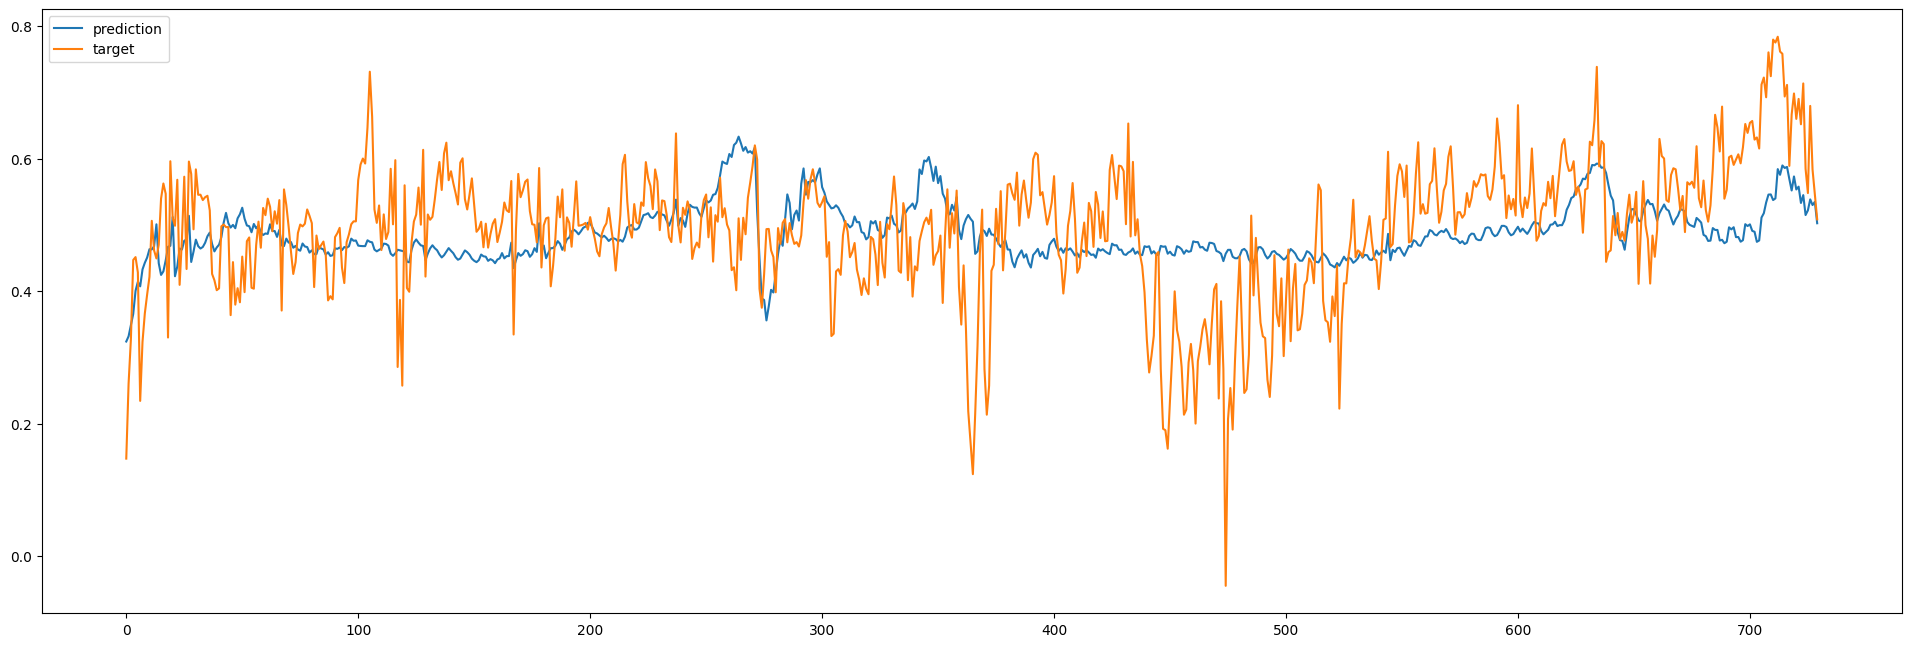

In [32]:
val = train_dataset.get('val')
print(val[0].shape)
enc_in = val[0]
dec_in = val[1]
target = val[2]

#a = predict_inf(infenc, infdec, enc_in, dec_in)
prediction = model.predict([enc_in, dec_in])
fig=plt.figure(figsize=(24,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(scaler_y.inverse_transform(prediction.reshape(prediction.shape[1],1)), label = 'prediction')
plt.plot(scaler_y.inverse_transform(target.reshape(-1,1)), label = 'target')
plt.legend()

### Metrics
Evaluate the results.

In [27]:
def print_results(target, prediction, scaler_y):
    print(f'Target Sum: {target.sum()}')
    print(f'Prediction Sum: {prediction.reshape(prediction.shape[1],1).sum()}')
    rescaled_pred = scaler_y.inverse_transform(prediction.reshape(-1,1))
    rescaled_target = scaler_y.inverse_transform(target.reshape(-1,1))
    target_value = np.absolute(rescaled_target[:]).sum()
    print(f'Rescaled target value Sum: {target_value}')
    pred_value = np.absolute(rescaled_pred[:]).sum()
    print(f'Rescaled prediction value Sum: {pred_value}')
    x = np.absolute(rescaled_target[:]-rescaled_pred[:]).sum()
    print(f'Absolute Error: {x}')
    print(f'Percentage Deviation: {x/target_value}')
    print(f'MAE: {mean_absolute_error(target, prediction.reshape(-1,1))}')
    print(f'MSE: {mean_squared_error(target, prediction.reshape(-1,1))}')
print_results(target, prediction ,scaler_y)

Target Sum: 359.4768482099146
Prediction Sum: 355.28875732421875
Rescaled target value Sum: 359.56679971365133
Rescaled prediction value Sum: 355.28875732421875
Absolute Error: 53.96906176598655
Percentage Deviation: 0.15009467450544922
MAE: 0.07393022159724186
MSE: 0.009281470223834087


In [33]:
print_results(target[:int(target.shape[0]/2)], prediction[:,:int(target.shape[0]/2)] ,scaler_y)

Target Sum: 178.40927095139148
Prediction Sum: 178.8157958984375
Rescaled target value Sum: 178.40927095139148
Rescaled prediction value Sum: 178.8157958984375
Absolute Error: 22.287717976078753
Percentage Deviation: 0.1249246625874681
MAE: 0.061062241030352744
MSE: 0.0062440798224159605


In [34]:
print_results(target[int(target.shape[0]/2):], prediction[:,int(target.shape[0]/2):] ,scaler_y)

Target Sum: 181.06757725852307
Prediction Sum: 176.47296142578125
Rescaled target value Sum: 181.1575287622598
Rescaled prediction value Sum: 176.47296142578125
Absolute Error: 31.681343789907796
Percentage Deviation: 0.17488284371269205
MAE: 0.08679820216413095
MSE: 0.012318860625252212


In [30]:
sum(abs(target))

359.5667997136511

In [31]:
results=scaler_y.inverse_transform(prediction.reshape(prediction.shape[1],1))
file_path = data_folder / "results4.csv"
pd.DataFrame(results).to_csv(file_path)
